In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [3]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

# Remove NaN values
df = df.dropna()

### Train-Test Split (without validation)

In [4]:
# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(df))
r_train, r_test = df['daily_return'][:train_size], df['daily_return'][train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]
train_size = len(r_train)
test_size = len(r_test)

print("Training Set:", r_train.shape, RV_train.shape)
print("Test Set:", r_test.shape, RV_test.shape)
print(r_train.index[0])
print(r_test.index[0])

Training Set: (2091,) (2091,)
Test Set: (523,) (523,)
2016-07-01 00:00:00
2022-04-30 00:00:00


#### General GARCH(p, q) formula

$y_t = x_t' b + \epsilon_t$

$\epsilon_t \mid \psi_{t-1} \sim \mathcal{N}(0, \sigma_t^2)$

$\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$


#### Use Garch(1,1)

$ r_t = \mu + \epsilon_t \\
\epsilon_t = \sigma_t e_t \\
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$

#### Training

In [5]:
p = 1
q = 1
model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
garch_fit = model.fit(disp="off")
params = garch_fit.params
mu = params['mu']
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]

# print model parameters
print("Model Parameters:")
print("Mu:", mu)
print("Omega:", omega)
print("Alpha:", alpha)
print("Beta:", beta)
print("alpha + beta > 1:", sum(alpha) + sum(beta) > 1)

Model Parameters:
Mu: 0.002670761189352288
Omega: 0.000301361415193104
Alpha: [0.1032088376637258]
Beta: [0.7971642001525506]
alpha + beta > 1: False


#### In-sample predictions

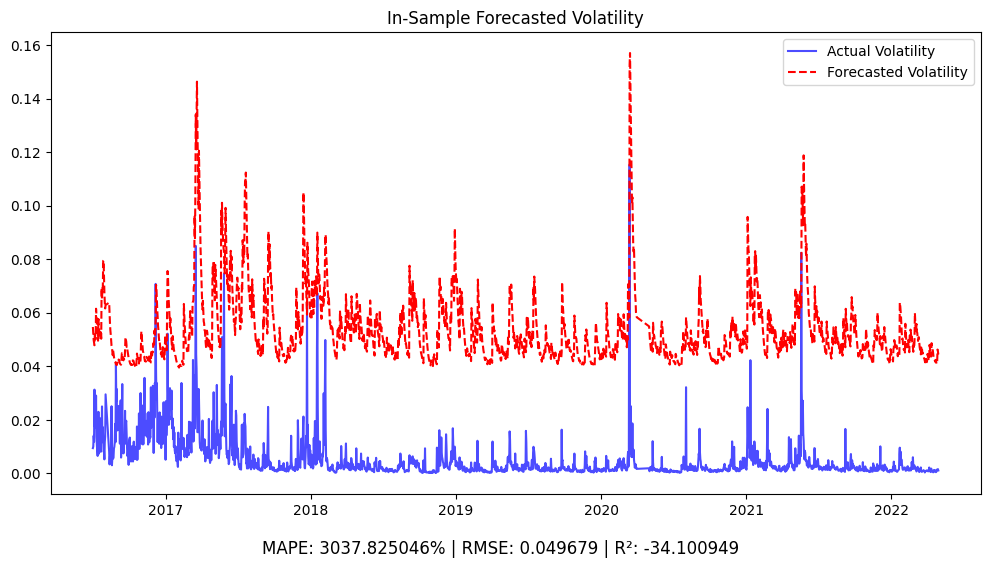

In [58]:
in_sample_forecast = garch_fit.conditional_volatility

# Calculate in-sample metrics
mse = mean_squared_error(RV_train, in_sample_forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_train, in_sample_forecast)
r2 = r2_score(RV_train, in_sample_forecast)

# Plot in-sample predictions with actual values
plt.figure(figsize=(12, 6))
plt.plot(RV_train, label='Actual Volatility', color="blue", alpha=0.7)
plt.plot(in_sample_forecast, label='Forecasted Volatility', color="red", linestyle="dashed")

plt.title("In-Sample Forecasted Volatility")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, 
            horizontalalignment='center', fontsize=12)
plt.show()

In [7]:
# save the GARCH(1,1) in-sample predictions to a csv file
df_in_samp_pred = pd.DataFrame({'Predicted Volatility': in_sample_forecast}, index=RV_train.index)
df_in_samp_pred.to_csv('../../results/models/GARCH_in_sample_1.csv')

#### Testing

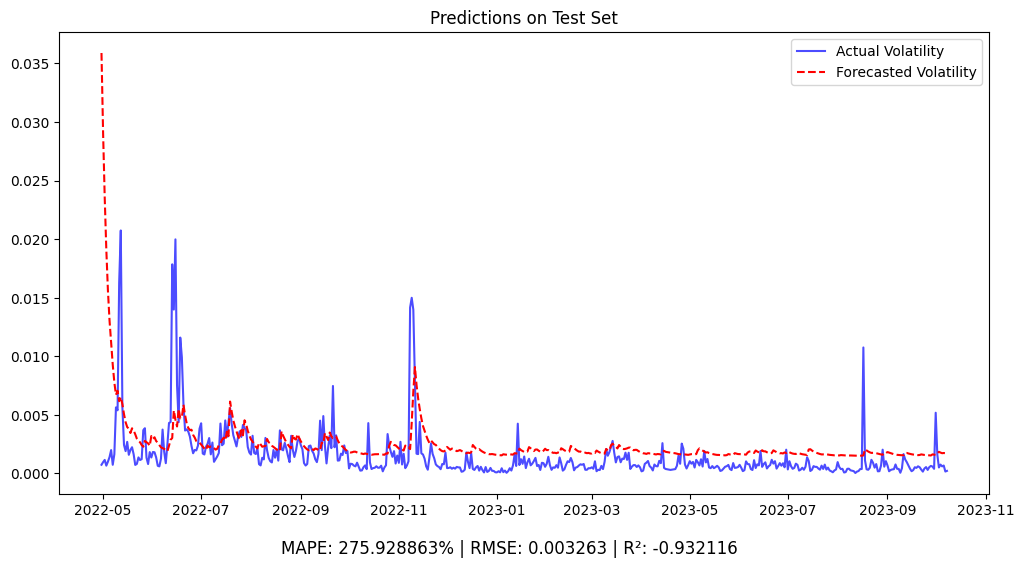

In [59]:
oos_pred = []
last_variance = garch_fit.conditional_volatility.iloc[-1]
last_return = r_train.iloc[-1]

for r in r_test:
    new_variance = omega
    new_variance += alpha[0] * (last_return - mu) ** 2
    new_variance += beta[0] * last_variance
    oos_pred.append(new_variance) 
    last_variance = new_variance
    last_return = r

# re index
oos_pred = pd.Series(oos_pred, index=r_test.index)

# Compute in-sample metrics
rmse = np.sqrt(mean_squared_error(RV_test, oos_pred))
mape = mean_absolute_percentage_error(RV_test, oos_pred)
r2 = r2_score(RV_test, oos_pred)

# Plot in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(RV_test, label="Actual Volatility", color="blue", alpha=0.7)
plt.plot(oos_pred, label="Forecasted Volatility", color="red", linestyle="dashed")
plt.title("Predictions on Test Set")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, 
            horizontalalignment='center', fontsize=12)
plt.show()


In [9]:
# save the GARCH(1,1) oos predictions to a csv file
df_oos_pred = pd.DataFrame({'Predicted Volatility': oos_pred}, index=RV_test.index)
df_oos_pred.to_csv('../../results/models/GARCH_oos_pred_1.csv')

### Hybrid Model

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv("../../data/ethusd_lasso_selected.csv") # 2016-07-01 to 2023-10-08
data['time'] = pd.to_datetime(data['time'])

# remove NaN values
data = data.dropna()
data.head()
garch_train= pd.read_csv("../../results/models/GARCH_in_sample_1.csv") # 2016-07-01 to 2022-04-29
garch_test = pd.read_csv("../../results/models/GARCH_oos_pred_1.csv") # 2022-04-30 to 2023-10-08
garch_test = garch_test.rename(columns={'0':'Predicted Volatility'})
garch_train['time'] = pd.to_datetime(garch_train['time'])
garch_test['time'] = pd.to_datetime(garch_test['time'])
garch = pd.concat([garch_train, garch_test])
garch['time'] = pd.to_datetime(garch['time'])

# inner join to get the same time period
data = pd.merge(data, garch, on='time', how='inner')
data = data.set_index('time')

# rename columns
data = data.rename(columns={'Predicted Volatility':'garch'})
data = data.dropna()

In [18]:
len(garch_train), len(garch_test), len(data)

(2091, 523, 2614)

In [13]:
# Define features & target
all_features = data.columns.tolist()
to_remove = ['time', 'open', 'daily_return' ,'RV_d,t', 'RV_w,t', 'RV_m,t']
features = [f for f in all_features if f not in to_remove]
target = 'ln_RV_d,t'  # Predicting next day's realized variance

# Create Input Sequences for LSTM
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])   # Past 60 days as input
        y.append(data[i+lookback, 0])  # Predicting next day's realized variance
    return np.array(X), np.array(y)

# Convert DataFrame to NumPy array for sequence creation
data_values = data[features].values
lookback = 60  # Use 60-day rolling window

# Create sequences
X, y = create_sequences(data_values, lookback)

In [ ]:
# Train-Test Split
# For X: 
# train is from (2016-07-01, 2016-09-06) to (2021-03-07, 2021-05-05)
# validation is from (2021-03-08, 2021-05-06) to (2022-04-29, 2022-06-27)
# test is from (2022-06-28, 2022-08-27) to (2023-08-09, 2023-10-07)

# For y:
# train is from 2016-09-07 to 2021-05-06
# validation is from 2021-05-07 to 2022-06-28
# test is from 2022-06-29 to 2023-10-08

X_train, X_test = X[:len(data)-len(garch_test)], X[len(data)-len(garch_test):]
y_train, y_test = y[:len(data)-len(garch_test)], y[len(data)-len(garch_test):]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Convert train data into correct shape
X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten() 
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Further split training into training & validation (80% train, 20% validation)
val_size = int(len(X_train) * 0.2)  # 20% of training data
X_val, y_val = X_train[-val_size:], y_train[-val_size:]  # Last 20% for validation
X_train, y_train = X_train[:-val_size], y_train[:-val_size]  # Remaining for training

print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Training Set: (1673, 60, 10) (1673,)
Validation Set: (418, 60, 10) (418,)
Test Set: (463, 60, 10) (463,)


In [46]:
# Define LSTM Model
model = Sequential([
    Input(shape=(lookback, len(features))),
    LSTM(256, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    LSTM(128, return_sequences=True, activation='tanh'), 
    Dropout(0.1),
    LSTM(64, return_sequences=True, activation='tanh'), 
    Dropout(0.1),
    LSTM(64, return_sequences=True, activation='tanh'), 
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation='tanh'), 
    Dropout(0.1),
    Dense(1, activation=None)
])

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), #set learning rate to half of default
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

# Train the LSTM Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #early stopping functionality
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=15, batch_size=16, verbose=1,
                    callbacks=[callback])

# Save the model
model.save('../../results/models/garch-lstm_model_1.keras')

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - loss: 0.6930 - mean_absolute_percentage_error: 157.4167 - root_mean_squared_error: 0.8207 - val_loss: 0.5724 - val_mean_absolute_percentage_error: 1293.2856 - val_root_mean_squared_error: 0.7469
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 0.5124 - mean_absolute_percentage_error: 162.6839 - root_mean_squared_error: 0.7061 - val_loss: 0.6761 - val_mean_absolute_percentage_error: 1846.7775 - val_root_mean_squared_error: 0.8152
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 0.5044 - mean_absolute_percentage_error: 145.6456 - root_mean_squared_error: 0.7019 - val_loss: 0.6223 - val_mean_absolute_percentage_error: 1369.6141 - val_root_mean_squared_error: 0.7825
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 0.4485 - mean_absolute_percentage_error: 154.5401 - root_mean_squared_error: 0.6620 - val_loss: 0.5867 - val_mean_absolute_percentage_error: 2239.4260 - val_root_mean_squared_error:

In [48]:
# Rolling Forecast for Test Set
predictions = []
history = np.array(X_train[-1])  # Convert last training window to numpy array

for i in range(len(X_test)):
    # Predict the next day's realized variance
    pred = model.predict(history.reshape(1, lookback, len(features)), verbose = 0)[0, 0]
    predictions.append(pred)

    # Use actual `y_test[i]` instead of `pred` for updating the rolling window
    new_entry = np.hstack([y_test[i], history[-1, 1:]])  # Keep actual value, retain other feature values
    history = np.vstack([history[1:], new_entry])  # Remove oldest, add new actual value

# Convert predictions back from log-scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
predictions = np.exp(predictions) 

# Save Predictions
results = pd.DataFrame({
    'time': data.index[len(data)-len(garch_test) + lookback:], 
    'RV_forecast': predictions.flatten()
})
results.to_csv("../../results/models/garch-lstm_forecast_1.csv", index=False)

In [50]:
# Load test set and inverse transform
test_actual = np.exp(scaler_y.inverse_transform(y_test.reshape(-1, 1)))[10:] 

# Load LSTM Forecasts
forecast_df = pd.read_csv("../../results/models/garch-lstm_forecast_1.csv")
lstm_predictions = forecast_df["RV_forecast"].values[10:]

# Calculate Error Metrics
mse = mean_squared_error(test_actual, lstm_predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_actual, lstm_predictions)
r2 = r2_score(test_actual, lstm_predictions)

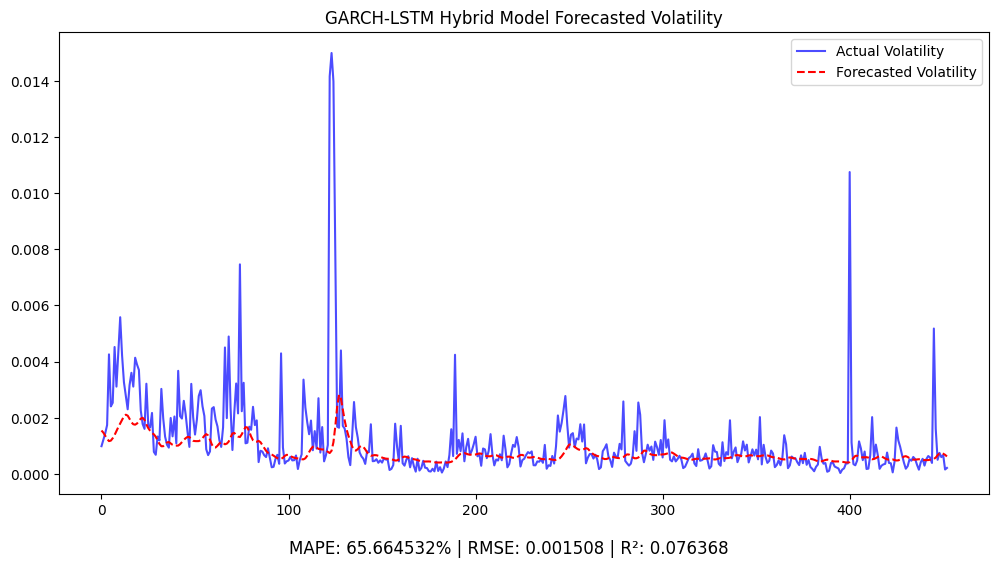

In [ ]:
# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_actual, label="Actual Volatility", color="blue", alpha=0.7)
plt.plot(lstm_predictions, label="Forecasted Volatility", color="red", linestyle="dashed")
plt.title("GARCH-LSTM Hybrid Model Forecasted Volatility")
plt.legend()

# Add Captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)

# Save Before Showing Plot
plt.savefig(f'../../results/figures/garch-lstm_forecast_plot_{lookback}_lookback_1.png')
plt.show()